In [1]:
import Flux
using Flux.Tracker, Statistics, DelimitedFiles
using Flux.Tracker: Params, gradient, update!
using Flux: gpu, Dense, relu, Chain, ADAM, Descent, params, throttle, Dropout, @epochs, testmode!

using Plots

using Base.Iterators: repeated

using DataFrames, DataFramesMeta, ExcelFiles, MLDataUtils, HDF5, ProgressMeter

using BSON: @save, @load
using NNlib

loaded


# DATA IMPORT

In [2]:
X_columns = h5read("./data/DataSet.hdf5", "X_columns")

X_entropy = h5read("./data/DataSet.hdf5", "X_entropy")
X_entropy_sc = h5read("./data/DataSet.hdf5", "X_entropy_sc")

X_tv = h5read("./data/DataSet.hdf5", "X_tv")
X_tv_sc = h5read("./data/DataSet.hdf5", "X_tv_sc")
y_tv = h5read("./data/DataSet.hdf5", "y_tv")

X_train = h5read("./data/DataSet.hdf5", "X_train")
X_train_sc = h5read("./data/DataSet.hdf5", "X_train_sc")
y_train = h5read("./data/DataSet.hdf5", "y_train")

X_valid = h5read("./data/DataSet.hdf5", "X_valid")
X_valid_sc = h5read("./data/DataSet.hdf5", "X_valid_sc")
y_valid = h5read("./data/DataSet.hdf5", "y_valid")

X_test = h5read("./data/DataSet.hdf5", "X_test")
X_test_sc = h5read("./data/DataSet.hdf5", "X_test_sc")
y_test = h5read("./data/DataSet.hdf5", "y_test")

X_scaler_mean = h5read("./data/DataSet.hdf5", "X_scaler_mean")
X_scaler_var = h5read("./data/DataSet.hdf5", "X_scaler_var")
println("loaded")
println("\nFeatures in X_ arrays are")
println(X_columns)
println("\nShape of X train and valid is")
println(size(X_tv))

loaded

Features in X_ arrays are
["sio2", "al2o3", "na2o", "k2o", "nbot", "ifsm", "ifst", "ap", "b", "T", "Sc", "tg", "ScT"]

Shape of X train and valid is
(13, 1145)


In [49]:
function prepare_datas(X_,y_)
    
    y = reshape(y_[:],1,length(y_))
    
    x = X_[1:4,:]
    ap = reshape(X_[8,:],1,size(X_,2))
    b = reshape(X_[9,:],1,size(X_,2))
    T = reshape(X_[10,:],1,size(X_,2))
    #be = reshape(X_[11,:],1,size(X_,2))
    sc = reshape(X_[11,:],1,size(X_,2))
    tg = reshape(X_[12,:],1,size(X_,2))
    return x, y, T, ap, b, sc, tg
end

function gkfolds(X_, y_, idx_label; k = 5)

    dd = kfolds(shuffleobs(unique(X_[idx_label,:])), k = k);
    
    out = []
    
    for j = 1:k
        train_lab, vald_lab = dd[j]
        train_idx = Int64[]
        valid_idx = Int64[]

        for i = 1:size(X_,2)
            if findall(X_[idx_label,i] .== train_lab) != []
                push!(train_idx, i)
            else
                push!(valid_idx, i)
            end
        end
        
        push!(out,((X_[:,train_idx],y_[train_idx]),(X_[:,valid_idx],y_[valid_idx])))
        
    end
    
    return out
end


gkfolds (generic function with 1 method)

In [50]:
nb_folds = 5
folds = gkfolds(X_train_sc,y_train,8,k=nb_folds);

folds_entropy = gkfolds(X_entropy_sc,X_entropy_sc[11,:],12,k=nb_folds);

# Model

In [51]:
# The model

#
# With two subnetworks for Be and Sc
#

function thousands(size)
    return ones(size).*log.(100000)
    end

function tens(size)
    return ones(size).*log(10)
end

function init_both(dims)
    return ones(dims).*[log.(100000.);log.(10.)]
end

m1 = Chain(
    Dense(4, 100, relu),
    #Dropout(0.2),
    Dense(100, 2,initb=init_both)) # |> gpu

Be(x) = reshape(exp.(m1(x[1:4,:])[1,:]),1,size(x,2))
ScTg(x) = reshape(exp.(m1(x[1:4,:])[2,:]),1,size(x,2))

# Other stuffs

Ae = param([-2.11])

tg(x) = Be(x)./((12.0.-Ae).*ScTg(x))

dCp(x,T, ap, b) = ap.*(log.(T).-log.(tg(x))) .+ b.*(T.-tg(x))

model(x,T, ap, b) = Ae .+ Be(x) ./ (T.* (ScTg(x) .+ dCp(x,T, ap, b)))

mse(yp, y) = sqrt(sum((yp .- y).^2)./size(y, 2))
mse_weighted(yp, y, w) = sqrt(sum((yp .- y).^2.0./(w.^2))./size(y, 2))

predict(x,T, ap, b) = model(x,T, ap, b)

# loss functions

loss_n(x, T, ap, b, y_target) = mse(model(x, T, ap, b), y_target)

loss_sc(x,sc) = mse(ScTg(x),sc)

loss_tg(x,target) = mse(tg(x),target)

loss_tg_sc(x,tg_target,sc_target) = loss_tg(x,tg_target) .+ loss_sc(x,sc_target).*1000.0

loss_global(x, T, ap, b, y_target, x2, tg2_target, sc2_target) = loss_n(x, T, ap, b, y_target) + loss_tg_sc(x2,tg2_target,sc2_target)


loss_global (generic function with 1 method)

# Training

# ENTROPY
With the entropy subset

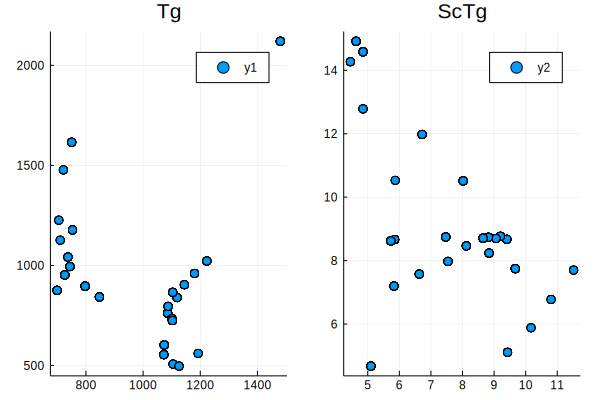

In [52]:
testmode!(m1)

scatter(([X_entropy_sc[12,:],X_entropy_sc[11,:]],
        [tg(X_entropy_sc).data[:],ScTg(X_entropy_sc).data[:]]),layout=2, 
    title=["Tg" "ScTg"])


In [81]:
#testmode!(m1)
testmode!(m1,false)

# SC training
record_loss_sc_train = Float64[]
record_loss_sc_valid = Float64[]

record_folds_train = Float64[]
record_folds_valid = Float64[]

#opt = Descent(0.001)
opt = ADAM(0.001)
fold_select = 1
nb_epochs = 1000

early_stop = 4
count_es = 0
count_es_record = zeros(nb_epochs)

p = ProgressMeter.Progress(nb_epochs, 1)   # minimum update interval: 1 second
for epoch_idx in 1:nb_epochs
    
    for j =1:nb_folds
        
        train,valid = folds_entropy[j]

        x_train_, y_train_, T_train_, ap_train_, b_train_, sc_train_, tg_train_ = prepare_datas(train[1],train[2])
        x_valid_, y_valid_, T_valid_, ap_valid_, b_valid_, sc_valid_, tg_valid_ = prepare_datas(valid[1],valid[2])

        evalcb = () -> (push!(record_folds_train, loss_tg_sc(x_train_, tg_train_, sc_train_).data),
            push!(record_folds_valid, loss_tg_sc(x_valid_, tg_valid_, sc_valid_).data))
        
        Flux.train!(loss_tg_sc, params(Ae,m1), [(x_train_, tg_train_, sc_train_)], opt, cb = throttle(evalcb, 1))

    end
    
    push!(record_loss_sc_train, 1.0./convert(Float64,nb_folds).*sum(record_folds_train))
    push!(record_loss_sc_valid, 1.0./convert(Float64,nb_folds).*sum(record_folds_valid))
    
    record_folds_train = Float64[]
    record_folds_valid = Float64[]
    
    ProgressMeter.update!(p, epoch_idx)
    
    # Early stopping criterion
    if epoch_idx > 1
        if record_loss_sc_valid[epoch_idx] > record_loss_sc_valid[epoch_idx-1]
        count_es += 1
        end
    end
    count_es_record[epoch_idx] = count_es
    if count_es > early_stop
        break;
    end
    
end

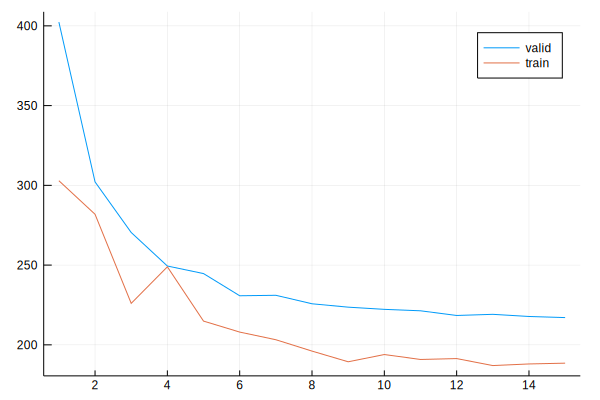

In [82]:
testmode!(m1)


# Plot
plot(record_loss_sc_train,label="valid")
plot!(record_loss_sc_valid,label="train")
#yscale("log")
#legend()

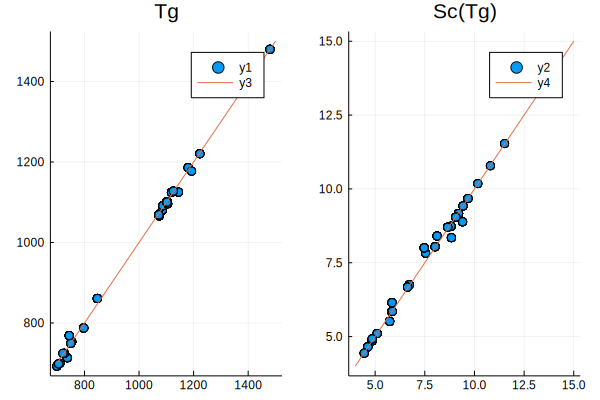

In [83]:
scatter([X_entropy_sc[12,:],X_entropy_sc[11,:]],
    [tg(X_entropy_sc).data[:],ScTg(X_entropy_sc).data[:]],
    layout=2, title=["Tg" "Sc(Tg)"])

plot!([[700;1500] [4;15]],[[700;1500] [4;15]])

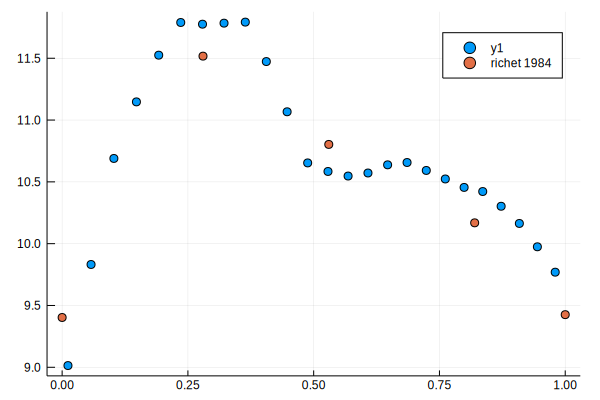

In [84]:
X_visu_NKS = h5read("./data/DataSet_visu.hdf5", "X_arti_NKS")
x_visu_xaxis = copy(X_visu_NKS)

for i = 1:7
    x_visu_xaxis[i,:] = X_visu_NKS[i,:].*sqrt.(X_scaler_var[i]) .+ X_scaler_mean[i]
end
#x_visu_xaxis = X_visu_NKS[4,:]
#./(X_visu_NKS[3,:].+X_visu_NKS[4,:])'

scatter(x_visu_xaxis[4,:]./(x_visu_xaxis[3,:].+x_visu_xaxis[4,:]),ScTg(X_visu_NKS).data'[:])
scatter!([0,0.28,0.53,0.82,1.0],[32.91,40.31,37.81,35.59,32.99]./7.0.*2.0,label="richet 1984")

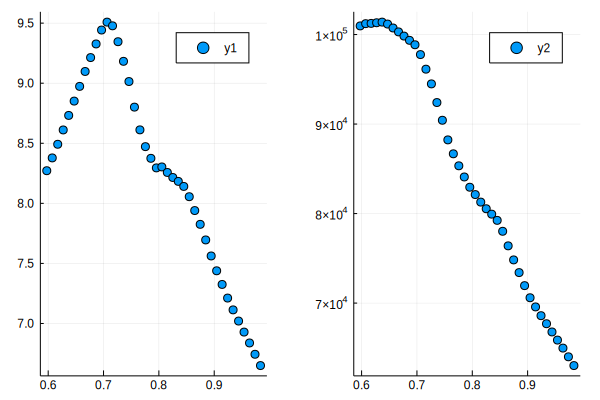

In [85]:
X_visu_NS = h5read("./data/DataSet_visu.hdf5", "X_arti_NS")
xns_visu_xaxis = copy(X_visu_NS)

for i = 1:7
    xns_visu_xaxis[i,:] = X_visu_NS[i,:].*sqrt.(X_scaler_var[i]) .+ X_scaler_mean[i]
end
#x_visu_xaxis = X_visu_NKS[4,:]
#./(X_visu_NKS[3,:].+X_visu_NKS[4,:])'

scatter([xns_visu_xaxis[1,:],xns_visu_xaxis[1,:]],
    [ScTg(X_visu_NS).data'[:],Be(X_visu_NS).data'[:]],
layout=2)
#scatter!([0,0.28,0.53,0.82,1.0],[32.91,40.31,37.81,35.59,32.99]./7.0.*2.0,label="richet 1984")

# VISCOSITY

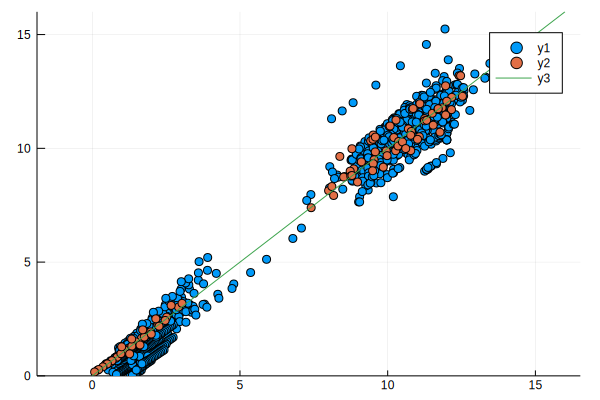

In [86]:
#x_tv_, y_tv_, T_tv_, ap_tv_, b_tv_, sc_tv_, tg_tv_ = prepare_datas(X_tv_sc,y_tv)

x_train_, y_train_, T_train_, ap_train_, b_train_, sc_train_, tg_train_ = prepare_datas(X_train_sc,y_train)
x_valid_, y_valid_, T_valid_, ap_valid_, b_valid_, sc_valid_, tg_valid_ = prepare_datas(X_valid_sc,y_valid)

scatter(y_train_[:],
    model(x_train_,T_train_,ap_train_, b_train_).data[:],)
scatter!(y_valid_[:],
    model(x_valid_,T_valid_,ap_valid_, b_valid_).data[:],)
plot!([0.,16.],[0.,16.],ylim=(0,16))

#println(loss(x_train,T_train, ap_train, b_train, y_train))

In [98]:
testmode!(m1,false)

opt = ADAM(0.001)
fold_select = 1
nb_epochs = 1000

early_stop = 50

###########

record_loss_n_train = Float64[]
record_loss_n_valid = Float64[]

record_folds_train = Float64[]
record_folds_valid = Float64[]

count_es = 0
count_es_record = zeros(nb_epochs)

p = ProgressMeter.Progress(nb_epochs, 1)   # minimum update interval: 1 second

x_train_, y_train_, T_train_, ap_train_, b_train_, sc_train_, tg_train_ = prepare_datas(X_train_sc,y_train)
x_valid_, y_valid_, T_valid_, ap_valid_, b_valid_, sc_valid_, tg_valid_ = prepare_datas(X_valid_sc,y_valid)
x2_, ~, ~, ~, ~, sc2_, tg2_ = prepare_datas(X_entropy_sc,X_entropy_sc[1,:]) 

dataset_global = [(x_train_, T_train_, ap_train_, b_train_, y_train_,x2_,sc2_,tg2_)]
dataset = [(x_train_, T_train_, ap_train_, b_train_, y_train_)]


for epoch_idx in 1:nb_epochs
    
        evalcb = () -> (push!(record_loss_n_train,loss_n(x_train_, T_train_ ,ap_train_, b_train_, y_train_).data),
        push!(record_loss_n_valid,loss_n(x_valid_, T_valid_ ,ap_valid_, b_valid_, y_valid_).data)) #@show(loss_be(x_train, be_train),loss_be(x_valid, be_valid))

        Flux.train!(loss_n, params(Ae,m1), dataset, opt, cb = throttle(evalcb, 1))
        #Flux.train!(loss_global, params(Ae,m1), dataset_global, opt, cb = throttle(evalcb, 1))
    
    ProgressMeter.update!(p, epoch_idx)
    
    # Early stopping criterion
    
    #if record_loss_n_valid[epoch_idx] < min_val
    #        @save "./model/m1.bson" m1
    #        @save "./model/Ae.bson" Ae
    #end
    
    if epoch_idx > 1
        if record_loss_n_valid[epoch_idx] > record_loss_n_valid[epoch_idx-1]
            count_es += 1
        end
    end
    
    if record_loss_n_valid[epoch_idx] .<= minimum(record_loss_n_valid)
        @save "m1.bson" m1
        @save "Ae.bson" Ae
    end
    
    # Save the best model on validation
    
    
    count_es_record[epoch_idx] = count_es
    if count_es > early_stop
        break;
    end
    
end


Progress:   7%|██▉                                      |  ETA: 0:00:41

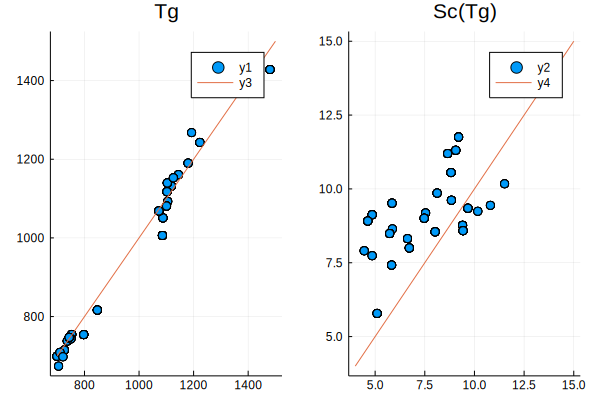

In [94]:
testmode!(m1)
scatter([X_entropy_sc[12,:],X_entropy_sc[11,:]],
    [tg(X_entropy_sc).data[:],ScTg(X_entropy_sc).data[:]],
    layout=2, title=["Tg" "Sc(Tg)"])

plot!([[700;1500] [4;15]],[[700;1500] [4;15]])

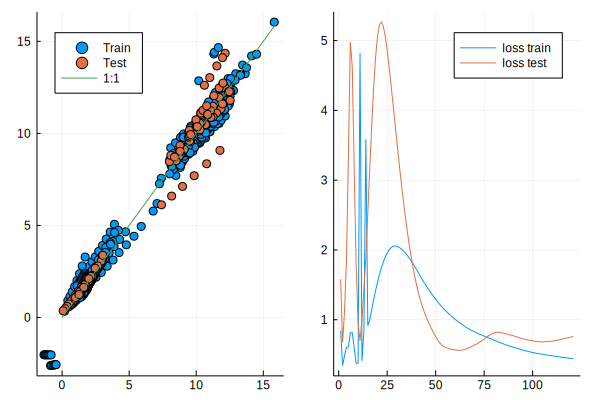

In [95]:
testmode!(m1)
#testmode!(m2)

x_train_, y_train_, T_train_, ap_train_, b_train_, sc_train_, tg_train_ = prepare_datas(X_train_sc,y_train)
x_valid_, y_valid_, T_valid_, ap_valid_, b_valid_, sc_valid_, tg_valid_ = prepare_datas(X_valid_sc,y_valid)

p1 = scatter(y_train_[:],
    model(x_train_,T_train_,ap_train_, b_train_).data[:],
    label="Train",legend=:topleft)
scatter!(y_valid_[:],
    model(x_valid_,T_valid_,ap_valid_, b_valid_).data[:],label="Test")
plot!([0.,16.],[0.,16.],label="1:1")


#p1 = scatter(y_tv[:],model(x_tv_,T_tv_,ap_tv_, b_tv_).data[:])

p2 = plot(collect(1:1:length(record_loss_n_train)),record_loss_n_train,label="loss train")

plot(p1,p2,layout=2)

plot!(collect(1:1:length(record_loss_n_valid)),record_loss_n_valid,subplot=2,label="loss test")
# plot(record_loss_n_train,label="valid")
# plot(record_loss_n_valid,label="train")
# yscale("log")
# legend()
#println(loss(x_train,T_train, ap_train, b_train, y_train))

In [96]:
# Manual save if needed
@save "./model/m1.bson" m1
@save "./model/Ae.bson" Ae

In [97]:
print(minimum(record_loss_n_train))
print("\n")
print(minimum(record_loss_n_valid))

0.34326348007801494
0.5626829284041726

# Loading BEST model

In [89]:
@load "m1.bson" m1
@load "Ae.bson" Ae

x_train_, y_train_, T_train_, ap_train_, b_train_, sc_train_, tg_train_ = prepare_datas(X_train_sc,y_train)
x_valid_, y_valid_, T_valid_, ap_valid_, b_valid_, sc_valid_, tg_valid_ = prepare_datas(X_valid_sc,y_valid)

p1 = scatter(y_train_[:],
    model(x_train_,T_train_,ap_train_, b_train_).data[:],
    label="Train",legend=:topleft,m=(3, :auto),
xlabel="Measured viscosity, log Pa s",
ylabel="Calculated viscosity, log Pa s")

scatter!(y_valid_[:],
    model(x_valid_,T_valid_,ap_valid_, b_valid_).data[:],label="Test",m=(3, :auto))
plot!([0.,16.],[0.,16.],label="1:1")

EOFError: EOFError: read end of file

# TEST

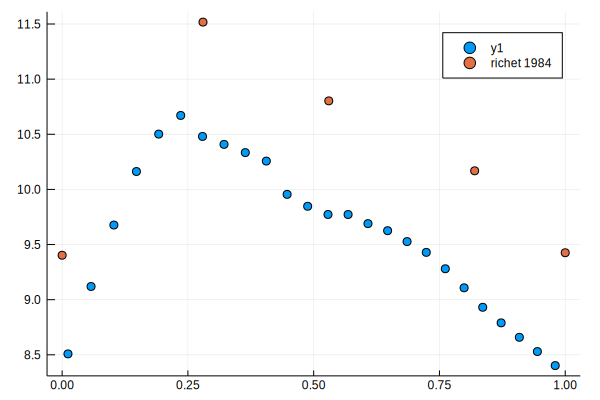

In [90]:
X_visu_NKS = h5read("./data/DataSet_visu.hdf5", "X_arti_NKS")
x_visu_xaxis = copy(X_visu_NKS)

for i = 1:7
    x_visu_xaxis[i,:] = X_visu_NKS[i,:].*sqrt.(X_scaler_var[i]) .+ X_scaler_mean[i]
end
#x_visu_xaxis = X_visu_NKS[4,:]
#./(X_visu_NKS[3,:].+X_visu_NKS[4,:])'

scatter(x_visu_xaxis[4,:]./(x_visu_xaxis[3,:].+x_visu_xaxis[4,:]),ScTg(X_visu_NKS).data'[:])
scatter!([0,0.28,0.53,0.82,1.0],[32.91,40.31,37.81,35.59,32.99]./7.0.*2.0,label="richet 1984")

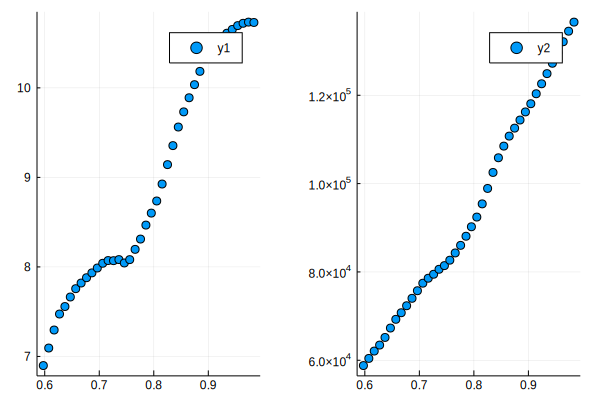

In [83]:
X_visu_NS = h5read("./data/DataSet_visu.hdf5", "X_arti_NS")
xns_visu_xaxis = copy(X_visu_NS)

for i = 1:7
    xns_visu_xaxis[i,:] = X_visu_NS[i,:].*sqrt.(X_scaler_var[i]) .+ X_scaler_mean[i]
end
#x_visu_xaxis = X_visu_NKS[4,:]
#./(X_visu_NKS[3,:].+X_visu_NKS[4,:])'

scatter([xns_visu_xaxis[1,:],xns_visu_xaxis[1,:]],
    [ScTg(X_visu_NS).data'[:],Be(X_visu_NS).data'[:]],
layout=2)
#scatter!([0,0.28,0.53,0.82,1.0],[32.91,40.31,37.81,35.59,32.99]./7.0.*2.0,label="richet 1984")

In [77]:
predictions_train = predict(x)

UndefVarError: UndefVarError: x not defined

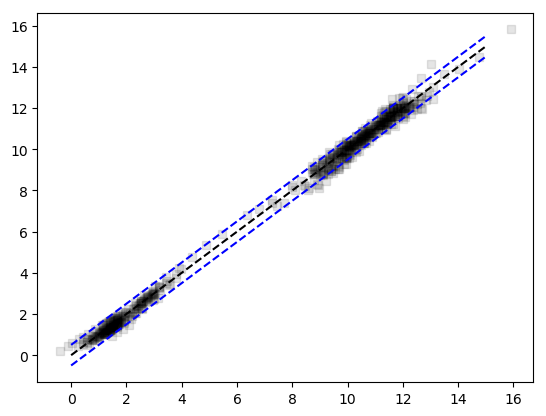

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f041fbb1cc0>

In [197]:
plot(predictions_train.data[:],y.parent[:],"ks",alpha=0.1)
plot([0,15],[0,15],"k--")
plot([0,15.0],[0,15.].-0.5,"b--")
plot([0,15.],[0,15.].+0.5,"b--")

In [195]:
plot([0,12]-0.5,[0,12]-0.5,"k--")

MethodError: MethodError: no method matching -(::Array{Int64,1}, ::Float64)
Closest candidates are:
  -(!Matched::Float64, ::Float64) at float.jl:397
  -(!Matched::Complex{Bool}, ::Real) at complex.jl:298
  -(!Matched::Missing, ::Number) at missing.jl:97
  ...

In [188]:
predictions_train.data[:]

620-element Array{Float64,1}:
  2.3032444067117757
  2.623692405633248 
  3.027915455938361 
  3.4222450165673743
  3.8926449255113944
  4.370103390672524 
  4.8876503648035   
  5.469334558026265 
  6.356743420865268 
  6.78613859050153  
  8.327278676684431 
  9.051372238986819 
  9.944407111041677 
  ⋮                 
  1.4055438658956634
  1.4422492073169009
  1.479413679478652 
  1.5170459511904548
  1.5551549108774632
  1.5937496735794525
  1.6328395882192055
  1.6724342451524592
  9.332781439644776 
 10.09932163190039  
 10.621319672155154 
 11.212695098263817 

In [191]:
m1(x)

Tracked 1×620 Array{Float32,2}:
 15123.9  15123.9  15123.9  15123.9  …  8035.39  8035.39  8035.39  8035.39